# RB1 and MCM

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re

import cptac
import cptac.utils as u

## Step 2: Find the mutation frequency of the gene of interest

In [2]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'RB1'

# Proteomics

In [3]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
omics_gene_list = ['MCM2','MCM3','MCM6']
prot_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = omics_gene_list) # single col level

In [4]:
# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['RB1_mutation_status'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_prot = mut_wt.drop(columns_to_drop, axis = 1)

In [5]:
binary_prot_melted = binary_prot.melt(id_vars='RB1_mutation_status')
binary_prot_melted

,RB1_mutation_status,Name,value
0,Mutated,MCM2_proteomics,0.865204
1,Mutated,MCM2_proteomics,0.943165
2,Wildtype,MCM2_proteomics,-0.236399
3,Mutated,MCM2_proteomics,-0.093372
4,Wildtype,MCM2_proteomics,-0.957693
...,...,...,...
292,Wildtype,MCM6_proteomics,0.440672
293,Wildtype,MCM6_proteomics,1.348624
294,Wildtype,MCM6_proteomics,-0.345955
295,Wildtype,MCM6_proteomics,-0.474821


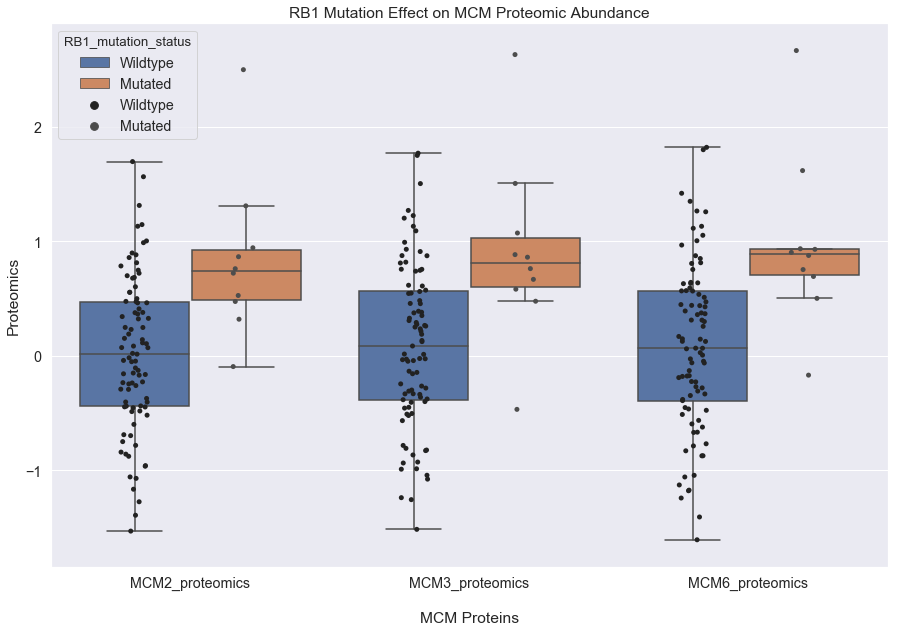

In [55]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='Name', y="value", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = binary_prot_melted, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Proteomic Abundance")
boxplot = sns.stripplot(x='Name', y="value", hue = 'RB1_mutation_status', data = binary_prot_melted, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Proteomics')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation= 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Phosphopoteomics MCM

In [7]:
phos_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = omics_gene_list)
flatten_phospho_and_mut = brain.reduce_multiindex(phos_mut, levels_to_drop=["Database_ID"], flatten=True)

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['RB1_mutation_status'] = flatten_phospho_and_mut['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else('Normal' if x == 'Wildtype_Normal' else 'Mutated'))

# Step 3 - Format
mut_wt = flatten_phospho_and_mut.loc[flatten_phospho_and_mut['Sample_Status'] == 'Tumor'] # drop normal
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = mut_wt.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('RB1_mutation_status', axis = 1)

# keep dataframe formatted to graph with normal samples
phospho_normal = flatten_phospho_and_mut.drop(columns_to_drop, axis = 1) # includes normal samples 

In [8]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'RB1_mutation_status', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status
11 significant comparisons!


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Comparison,P_Value
0,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK,9.811491e-08
1,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,2.610996e-07
2,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,2.761099e-05
3,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,9.685043e-05
4,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,9.706725e-05
5,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,1.171451e-04
6,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDE...,1.244903e-04
7,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR,3.395965e-04
8,MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*...,6.866016e-04
9,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,8.706963e-04


In [15]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites

phospho_df_RB1 = pd.melt(binary_phospho, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)
phospho_df_RB1
sp = list(phospho_df_RB1['specific_phospho'].unique())
sp

['MCM6_S762',
 'MCM3_S205',
 'MCM3_S756T758',
 'MCM3_S717T719',
 'MCM3_S713S717T719',
 'MCM2_S108',
 'MCM2_S139',
 'MCM3_S717T719S726',
 'MCM2_S41']

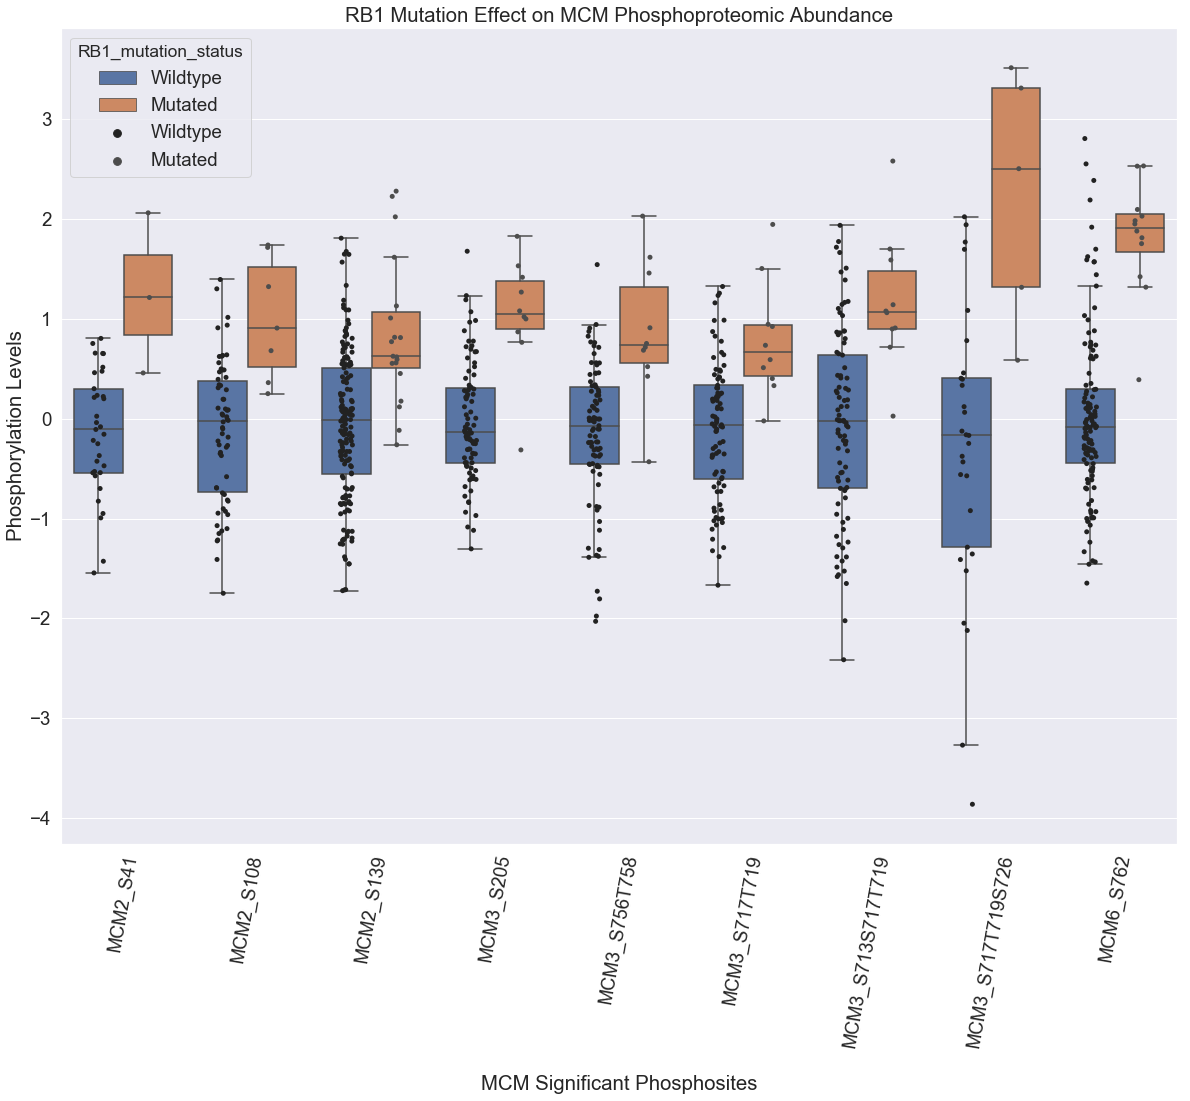

In [57]:
# Visualize 
plt.rcParams['figure.figsize']=(20,15)#size of plot
sns.set(font_scale = 1.7)

#plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                          hue_order = ['Wildtype', 'Mutated'],
                          order = ['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'],
                          data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_RB1, jitter = True, 
                           color = ".3",dodge = True, hue_order = ['Wildtype', 'Mutated'],
                           order=['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'])
boxplot.set(xlabel = "\nMCM Significant Phosphosites", ylabel = 'Phosphorylation Levels')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Normalize phopho

Data already is log transformed. To normalize Phosphoproteomics - Proteomics

In [ ]:
['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762']

In [23]:
MCM2_phospho = ['MCM2_S108','MCM2_S139','MCM2_S41']
MCM3_phospho = ['MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726']
MCM6_phospho = ['MCM6_S762']
MCM = {'MCM2': MCM2_phospho, 'MCM3': MCM3_phospho, 'MCM6':MCM6_phospho}

In [44]:
phospho_list.to_frame()
phospho_list.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_list.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                    inplace = True, regex = True)


sig_phos = pd.DataFrame()
for site in phospho_list:
    sig_phos = sig_phos.append(binary_phospho[site])
    
sig_phos = sig_phos.transpose()
for col in sig_phos.columns:
    sig_phos.replace(to_replace = '_phosphoproteomics', value = '', 
                            inplace = True, regex = True) # shorten column names
    sig_phos.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

sig_phos

AttributeError: 'list' object has no attribute 'to_frame'

In [ ]:
omics_gene_list = ['MCM2','MCM3','MCM6']
for gene in omics_gene_list:
    phos_df[i] = phos_df[i] - prot_df[gene]

In [12]:
# Subtract phosphoproteomics from proteomic data for each protein 
def normalize(phos_df, prot_df, gene):
    for i in phos_col_list:
        phos_df[i] = phos_df[i] - prot_df[gene]
    return phos_df


prot = brain.get_proteomics()
for gene in omics_gene_list:
    prot_gene = prot[gene]
    #print(prot_gene)

phospho_list
    
prot_gene = prot[['MCM2']]
phos_gene = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = phospho_list)
phos_gene = brain.reduce_multiindex(phos_gene, levels_to_drop=["Database_ID"], flatten=True)

phos_gene = phos_gene.iloc[:,:-4]
df = normalize(phos_gene, prot_gene, 'MCM2')
prot_gene

KeyError: 'MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR'

In [ ]:
# Normalize data [0,1]
min_val = float(phospho_df_RB1.min()[2])
max_val = float(phospho_df_RB1.max()[2])
delta = max_val - min_val

for cols, row in only_phospho.iter:
    i = int(i)
    (i - min_val)/delta
    #normalized_only_phospho = only_phospho.apply(lambda x: (x - min_val)/delta) # FIX

bin_series = binary_phospho['RB1_mutation_status']
norm_phos = normalized_only_phospho.join(bin_series)

In [ ]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test
print("Doing t-test comparison for normalized phos")
phos_pval_results_norm = u.wrap_ttest(norm_phos, 'RB1_mutation_status', phos_col_list)
phos_pval_results_norm

In [ ]:
phospho_list_norm = list(phos_pval_results_norm['Comparison'])

phospho_df_RB1_norm = pd.melt(norm_phos, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1_norm.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1_norm.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)
phospho_df_RB1_norm

In [ ]:
# Normalize data [0,1] for graphing
min_val = float(phospho_df_RB1.min()[2])
max_val = float(phospho_df_RB1.max()[2])
delta = max_val - min_val
phospho_df_RB1['phosphoproteomics'] = phospho_df_RB1['phosphoproteomics'].map(lambda x: (x - min_val)/delta if type(x) == float else x)
phospho_df_RB1

In [ ]:
# Visualize NORMALIZED
#plt.rcParams['figure.figsize']=(20,15) #size of plot
sns.set(font_scale = 1.7)

plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_RB1, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
# Visualize 
#plt.rcParams['figure.figsize']=(15,8)#size of plot
sns.set(font_scale = 1.7)

plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = phospho_df_RB1, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Complex", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites

n_phos = pd.melt(phospho_normal, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
n_phos.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
n_phos.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

n_phos

In [ ]:
# Visualize
#plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.7)

plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Normal','Wildtype', 'Mutated'], data = n_phos, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = n_phos, jitter = True, 
                           color = ".3", hue_order = ['Normal','Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "Significant trans Genes (all protein comparison)", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

plt.show()
plt.clf()
plt.close()